In [3]:
# activate clip env
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import os
import clip
import torch
import pandas as pd
import random
from torchvision import transforms
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.utils.tensorboard 
from torch.utils.tensorboard import SummaryWriter

import warnings
warnings.filterwarnings("ignore", message=".*pandas only supports SQLAlchemy connectable.*")

torch.cuda.empty_cache()
print(f'GPU is available: {torch.cuda.is_available()}')
print("Torch version:", torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"

2023-11-13 16:29:29.913115: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-13 16:29:29.931659: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 16:29:29.931677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 16:29:29.931689: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 16:29:29.935469: I tensorflow/core/platform/cpu_feature_g

GPU is available: True
Torch version: 2.1.0+cu118


In [4]:
# PATHs
PROJECT_DATA_PATH='//home/bule/projects/MVTec_Visualizer/data/mvtec_anomaly_detection'
LOG_DIR= '/home/bule/projects/MVTec_Visualizer/tensorboard_logs'

In [5]:
FILENAME = 'MVTEC_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))

## Uncomment to filter for category
# category = 'bottle' # categories = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
# # filter for category 
# df = df[df.index.str.contains(category)]
# df = df[df.index.str.contains('good')]

image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))


In [7]:
##train
num_epochs = 20  # Set the number of epochs

# Check for GPU and set the default device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator definition
class Generator(nn.Module):
    def __init__(self, embedding_dim, img_shape):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.model = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Linear(128, torch.prod(torch.tensor(img_shape)).item()),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Discriminator definition
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        validity = self.model(flattened)
        return validity

# Custom dataset definition
class CustomDataset(Dataset):
    def __init__(self, image_paths, embeddings_df, transform=None):
        self.image_paths = image_paths
        self.embeddings_df = embeddings_df
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert('RGB')
        embedding = self.embeddings_df.loc[img_path].values.astype('float32')
        if self.transform:
            image = self.transform(image)
        return image.to(device), torch.tensor(embedding).to(device)

# Image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Assuming 'image_paths' is a list of file paths and 'df' is your DataFrame with embeddings
# image_paths = [...]
# df = pd.DataFrame(...)

# Initialize generator and discriminator with the correct device
img_shape = (3, 64, 64)  # Example image shape
embedding_dim = 512  # Example embedding size from CLIP
generator = Generator(embedding_dim=embedding_dim, img_shape=img_shape).to(device)
discriminator = Discriminator(img_shape=img_shape).to(device)

# Loss function and optimizers
adversarial_loss = torch.nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Dataset and Dataloader
dataset = CustomDataset(image_paths, df, transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    for i, (imgs, embeddings) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(embeddings)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')


KeyboardInterrupt: 

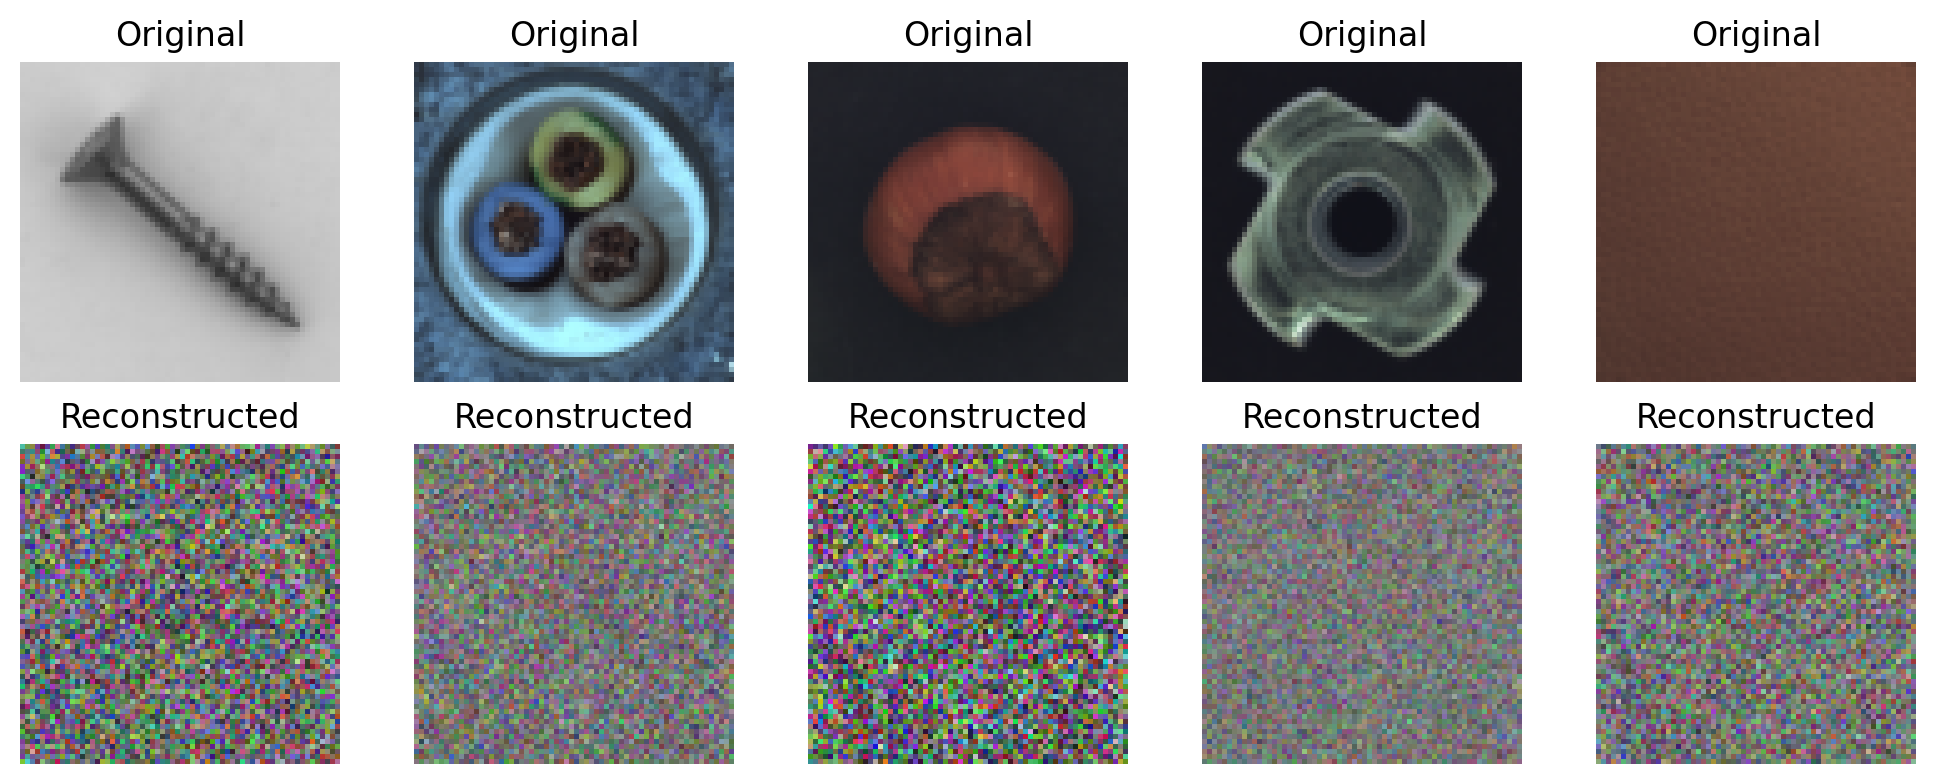

In [8]:
## generate from training samples

# Load the generator from the given path
generator_path = '/home/bule/projects/MVTec_Visualizer/generator.pth'
generator = Generator(embedding_dim=embedding_dim, img_shape=img_shape).to(device)
generator.load_state_dict(torch.load(generator_path))

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to denormalize image for visualization
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Assuming mean=0.5, std=0.5 for normalization

# Function to display images
def show_images(original, reconstructed):
    num_images = len(original)
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # Display original image
        plt.subplot(2, num_images, i + 1)
        image = denormalize(original[i]).permute(1, 2, 0).cpu().numpy()
        plt.imshow(image)
        plt.title('Original')
        plt.axis('off')

        # Display reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        image = denormalize(reconstructed[i]).permute(1, 2, 0).cpu().numpy()
        plt.imshow(image)
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming 'generator' is your trained generator model
# Assuming 'df' is your dataframe where the index is image paths and the columns are the embeddings
generator.eval()

# Number of images to sample
num_samples = 5

# Sample random embeddings and their corresponding image paths
sample_indices = np.random.choice(df.index, size=num_samples, replace=False)
sample_embeddings = torch.stack([torch.tensor(df.loc[idx].values).float() for idx in sample_indices]).to(device)
sample_images_paths = [path for path in sample_indices]

# Transform for the images (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the size expected by the generator
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and transform the original images
original_images = [transform(Image.open(path).convert('RGB')) for path in sample_images_paths]
original_images = torch.stack(original_images).to(device)

# Generate the reconstructed images from the embeddings
with torch.no_grad():
    reconstructed_images = generator(sample_embeddings).to(device)

# Show original and reconstructed images
show_images(original_images, reconstructed_images)


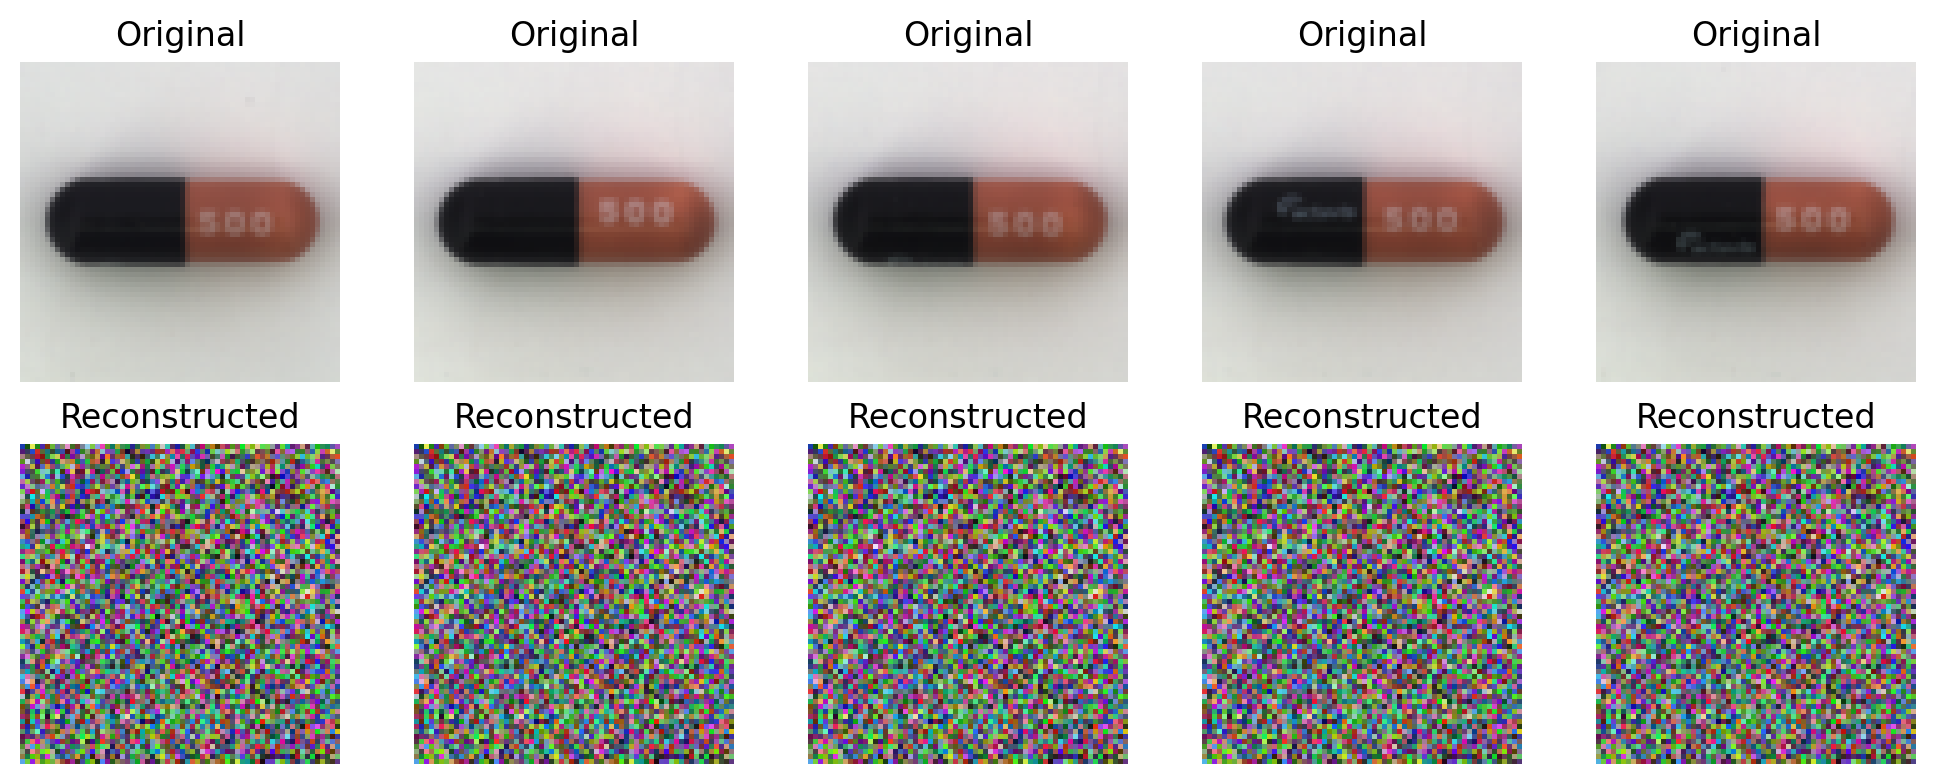

In [9]:
generator.eval()

FILENAME = 'MVTEC_embeddings_df'
df = pd.read_pickle(os.path.join(PROJECT_DATA_PATH,FILENAME+'.pkl'))

category = 'capsule' # categories = ['bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut', 'leather', 'metal_nut', 'pill', 'screw', 'tile', 'toothbrush', 'transistor', 'wood', 'zipper']
# filter for category 
df = df[df.index.str.contains(category)]
df = df[df.index.str.contains('good')]

image_paths=[pts[1:]for pts in df.index]
df = df.set_index(pd.Index(image_paths))


# Number of images to sample
num_samples = 5

# Sample random embeddings and their corresponding image paths
sample_indices = np.random.choice(df.index, size=num_samples, replace=False)
sample_embeddings = torch.stack([torch.tensor(df.loc[idx].values).float() for idx in sample_indices]).to(device)
sample_images_paths = [path for path in sample_indices]

# Transform for the images (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to the size expected by the generator
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load and transform the original images
original_images = [transform(Image.open(path).convert('RGB')) for path in sample_images_paths]
original_images = torch.stack(original_images).to(device)

# Generate the reconstructed images from the embeddings
with torch.no_grad():
    reconstructed_images = generator(sample_embeddings).to(device)

# Show original and reconstructed images
show_images(original_images, reconstructed_images)
